In [158]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [159]:
df_results = pd.read_csv("../Results/InvestmentModelResults/Loop_4models_neighbors_only_v2_8760.csv")

In [160]:
#Export revenues and congestion rents should be dealt with with opposite signs
neg_components = ["cong_rent_e","export_rev"]
df_results[neg_components] = -df_results[neg_components]

#Split congestion rents equally between neighbors
rents = ['cong_rent_i', 'cong_rent_e']
df_results[rents] = df_results[rents]/2

#Combine operational cost components 
operational_costs = ['CO2_cost', 'load_shedding_cost', 'VOM_cost', 'fuel_cost']
df_results["Operational costs"] = df_results[operational_costs].sum(axis=1)

cost_vals = ['CO2_cost', 'load_shedding_cost', 'VOM_cost', 'fuel_cost','investment_cost', 'export_rev',"import_cost", 'cong_rent_i', 'cong_rent_e']
df_results["Total cost"] = df_results[cost_vals].sum(axis=1)

In [161]:
def create_model_type_name(row,columns):
    strings = [str(row[col]) for col in columns if pd.notna(row[col])]
    return '-'.join(strings)

In [162]:
##Start with some renaming for clarity 
geo_scope_map = {
    'DE00_NL00_FR00_UK00_BE00_LUG1': 'DN',
    'N_A': ''
}
df_results["geoscope_m"] = df_results["geoscope"].map(geo_scope_map)

# List of columns to consider for joining
columns_to_join = ['type', 'trans_cap_other', 'geoscope_m', 'stepsize']

# Apply the function row-wise to create the new column
df_results['name'] = df_results.apply(create_model_type_name, args=(columns_to_join,), axis=1)

name_map = {
    'NTC-1.0e10-DN': 'NTC-Inf',
    'NTC-1.0e10-All': 'SN-All',
    'NTC-S-All': "NTC-All",
    'NTC-S-DN': "NTC",
    'TCPC-DN': "TCPC",
    "isolated-" : "Isolated",
    "TCS-DN-100.0": "TCS-100",
    "TCS-DN-1000.0": "TCS-1000",
    "TCS-DN-10.0": "TCS-10",
    "TCS-DN-1.0": "TCS-1",
    "NTC-0-DN": "NTC-0"

}
df_results['Model Type'] = df_results["name"].replace(name_map)


In [163]:
# Get deviations from benchmark model
bm_t = "NTC"

# Filter the DataFrame for the benchmark model
col_bm = df_results[(df_results["Model Type"] == bm_t)]

# Initialize an empty list to store deviations
dev_data = []

vals_dev = ["CCGT", "OCGT", "PV", "w_off", "w_on"]

# Calculate deviations from the benchmark model
for index, row in df_results.iterrows():
    t = row["type"]
    stepsize = row["stepsize"]
    trans_cap_other = row["trans_cap_other"]
    model_type = row["Model Type"]
    deviations = row[vals_dev] - col_bm.iloc[0][vals_dev]  # Accessing the first row of col_bm for deviations
    
    # Create a dictionary for the deviations
    dev_dict = {"Model Type":model_type,"type": t, "stepsize": stepsize, "trans_cap_other": trans_cap_other}
    for col, dev in zip(vals_dev, deviations):
        dev_dict[col] = dev
    
    # Append the dictionary to the list
    dev_data.append(dev_dict)

# Create DataFrame from the list of dictionaries
dev_df = pd.DataFrame(dev_data)

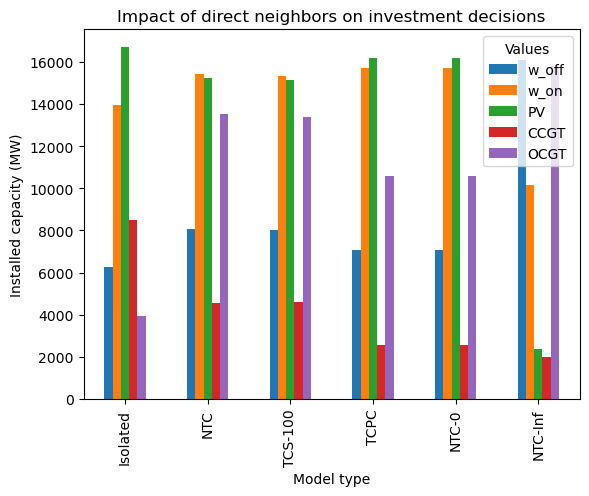

In [164]:
## Plot installed capacities 

# Define the types to include and order in which you want the types to appear
type_order = ["Isolated","NTC","TCS-100","TCPC","NTC-0","NTC-Inf"]
filter_condition = df_results["Model Type"].isin(type_order)

filtered_df = df_results[filter_condition].set_index("Model Type").reindex(type_order).reset_index()

#Choose the values to be displayed
stacked = False
if stacked: 
    vals= ["CCGT", "OCGT","PV","w_on","w_off"]
else:
    vals = [ "w_off", "w_on","PV","CCGT", "OCGT"]
#vals = ["imported","exported"]


filtered_df.plot.bar(x="Model Type", y=vals, stacked=stacked)

plt.xlabel('Model type')
plt.ylabel('Installed capacity (MW)')
plt.title('Impact of direct neighbors on investment decisions')
plt.legend(title='Values')
#plt.show()
plt.savefig(f"../Results/Figures/FY_analysis/DirectNeighbors//Installed_capacities_bar_{stacked}_DN.png")

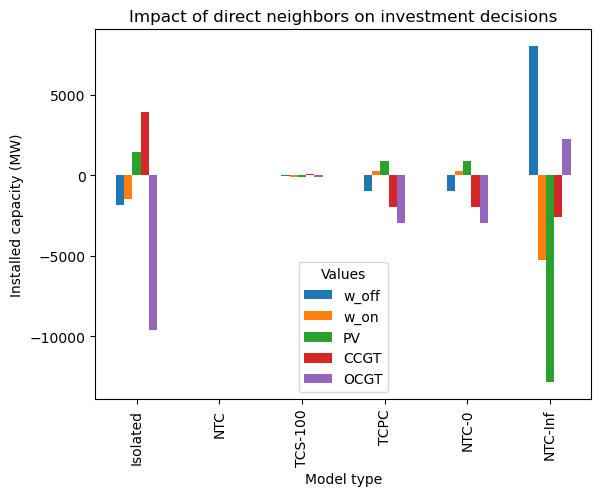

In [165]:
## Plot installed capacity deviations

# Define the types to include and order in which you want the types to appear
type_order = ["Isolated","NTC","TCS-100","TCPC","NTC-0","NTC-Inf"]
filter_condition = df_results["Model Type"].isin(type_order)

filtered_df = dev_df[filter_condition].set_index("Model Type").reindex(type_order).reset_index()

#Choose the values to be displayed
stacked = False
if stacked: 
    vals= ["CCGT", "OCGT","PV","w_on","w_off"]
else:
    vals = [ "w_off", "w_on","PV","CCGT", "OCGT"]
#vals = ["imported","exported"]


filtered_df.plot.bar(x="Model Type", y=vals, stacked=stacked)

plt.xlabel('Model type')
plt.ylabel('Installed capacity (MW)')
plt.title('Impact of direct neighbors on investment decisions')
plt.legend(title='Values')
#plt.show()
plt.savefig(f"../Results/Figures/FY_analysis/DirectNeighbors//Installed_capacities_deviations_bar_{stacked}_DN.png")

In [166]:
df_results["Total cost"]

0   -8.885616e+09
1    5.907149e+09
2    4.020003e+09
3   -8.093713e+09
4    4.558322e+09
5    4.026348e+09
6    3.974977e+09
7    3.968468e+09
8    3.968131e+09
Name: Total cost, dtype: float64

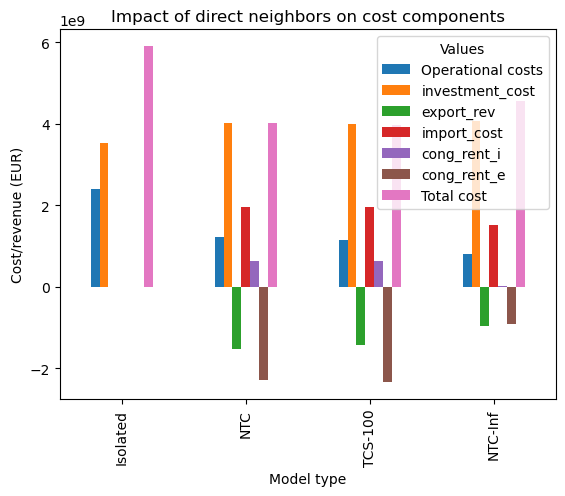

In [167]:
##Plot cost components
# Define the types to include and order in which you want the types to appear
type_order = ["Isolated","NTC","TCS-100","NTC-Inf"]
filter_condition = df_results["Model Type"].isin(type_order)

filtered_df = filtered_df = df_results[filter_condition].set_index("Model Type").reindex(type_order).reset_index()

vals = ["Operational costs",
       'investment_cost', 'export_rev',"import_cost", 'cong_rent_i', 'cong_rent_e']
vals_tot = ["Operational costs",
       'investment_cost', 'export_rev',"import_cost", 'cong_rent_i', 'cong_rent_e', "Total cost"]
#vals_tot = "Total cost"

#vals = ["imported","exported"]

stacked = False
filtered_df.plot.bar(x="Model Type", y=vals_tot, stacked=stacked)

plt.xlabel('Model type')
plt.ylabel('Cost/revenue (EUR)')
plt.title('Impact of direct neighbors on cost components')
plt.legend(title='Values')
#plt.show()
plt.savefig(f"../Results/Figures/FY_analysis/DirectNeighbors/Cost_components_bar_s{stacked}_DN.png")

In [ ]:
##Plot cost components

filter_condition = ((df_results["trans_cap_other"].isin(["S", "1.0e10"])) | pd.isna(df_results["trans_cap_other"])) & ((df_results["stepsize"] == 100) | (pd.isna(df_results["stepsize"])))

# Define the order in which you want the types to appear
#type_order = ["NTC-DN", "NTC-All", "TCS-All", "TCPC","SN-All"]
type_order = ["Isolated","NTC","TCS-100","TCPC","SN"]
filtered_df = filtered_df = df_results[filter_condition].set_index("Model Type").reindex(type_order).reset_index()

vals = [""]
vals_tot = ["Operational costs",
       'investment_cost', 'export_rev',"import_cost", 'cong_rent_i', 'cong_rent_e', "Total cost"]

#Export revenues and congestion rents should be dealt with with opposite signs
neg_components = ["cong_rent_e","export_rev"]
filtered_df[neg_components] = -filtered_df[neg_components]

#Split congestion rents equally between neighbors
rents = ['cong_rent_i', 'cong_rent_e']
filtered_df[rents] = filtered_df[rents]/2

#Combine operational cost components 
operational_costs = ['CO2_cost', 'load_shedding_cost', 'VOM_cost', 'fuel_cost']
filtered_df["Operational costs"] = filtered_df[operational_costs].sum(axis=1)


filtered_df["Total cost"] = filtered_df[vals].sum(axis=1)


#vals = ["imported","exported"]

stacked = False
filtered_df.plot.bar(x="Model Type", y=vals_tot, stacked=stacked)

plt.xlabel('Model type')
plt.ylabel('Cost/revenue (EUR)')
plt.title('Impact of direct neighbors on cost components')
plt.legend(title='Values')
#plt.show()
plt.savefig(f"../Results/Figures/FY_analysis/IndirectNeighbors/Cost_components_bar_s{stacked}_DN.png")